# Cloud coverage using images collected from Sentinel-2 combined with IRIS manual classification and CNN supervised learning




---




The point of this project is to create a convoluted neural network model which can classify cloud coverage. This notebook allows users to:




*   Search the copernicus data base, using set date periods and geographical areas
*   Check masks created in iris against the image region and prepare them for use in model creation
*   Create CNN model and save it for user rollout
*   Validation checks (confusion matrix, accuracy-loss plot) as well as calculating percentage of area covered by cloud


Some of these segments are not required or can be completed by other means, such as data image colleciotn, however for the sake of completeness and user comfot they have been included to sow the full process.


For a more detailed explanation of This notebook, users are directed to:https://github.com/will-wads/AI4EO-final-project/tree/main



# **Essential packages and mounting drive space**
Everything loaded in by these cells are essential for future functions, and also provide a space to and load variables and data.


In [ ]:
# Import all packages needed
from datetime import datetime, timedelta
from shapely.geometry import Polygon, Point
import numpy as np
import requests
import pandas as pd
from shapely.geometry import Polygon
from xml.etree import ElementTree as ET
from shapely.geometry import Polygon
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

KeyboardInterrupt: 

In [ ]:
!pip install rasterio

!pip install netCDF4 matplotlib numpy

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

# **Accessing Copernicus**


---

In order to download and access Copernicus, The notebook needs to be able to access the website and log in, as well as ensure that a product download is possible, the cell below is responsible for ensuring this is possible. The cell also features a "polygon", which users can change to switch the area of the globe they want to search the database for, functioning primarily on the World Geodetic System 1984 (WGS 84)


In [ ]:
def make_api_request(url, method="GET", data=None, headers=None):

    global access_token

    if not headers:

        headers = {"Authorization": f"Bearer {access_token}"}



    response = requests.request(method, url, json=data, headers=headers)

    if response.status_code in [401, 403]:

        global refresh_token

        access_token = refresh_access_token(refresh_token)

        headers["Authorization"] = f"Bearer {access_token}"

        response = requests.request(method, url, json=data, headers=headers)
    elif response.status_code != 200:
        print(f"API request failed with status code: {response.status_code} - {response.text}")

    return response




def query_sentinel2_data(start_date, end_date, token):
    """
    Queries Sentinel-2 Level-2A data for the specified region region.
    Returns a DataFrame with metadata for available satellite imagery.
    """
    all_data = []

    polygon = (
     "POLYGON((-0.856 52.042, -0.856 52.048, -0.842 52.048, -0.842 52.042, -0.856 52.042))"
    )

    filter_string = (
        f"Collection/Name eq 'SENTINEL-2' and "
        f"Attributes/OData.CSC.StringAttribute/any(att: att/Name eq 'productType' and att/Value eq 'S2MSI2A') and "
        f"ContentDate/Start gt {start_date}T00:00:00.000Z and ContentDate/End lt {end_date}T23:59:59.999Z"
    )

    next_url = (
        f"https://catalogue.dataspace.copernicus.eu/odata/v1/Products?"
        f"$filter={filter_string} and "
        f"OData.CSC.Intersects(area=geography'SRID=4326;{polygon}')&"
        f"$top=1000"
    )

    headers = {"Authorization": f"Bearer {token}"}

    while next_url:
        response = make_api_request(next_url, headers=headers)
        if response.status_code == 200:
            data = response.json()["value"]
            all_data.extend(data)
            next_url = response.json().get("@odata.nextLink")
        else:
            print(f"Error fetching data: {response.status_code} - {response.text}")
            break

    return pd.DataFrame(all_data)




def get_access_and_refresh_token(username, password):

    """Retrieve both access and refresh tokens."""

    url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"

    data = {

        "grant_type": "password",

        "username": username,

        "password": password,

        "client_id": "cdse-public",

    }
    try:
        response = requests.post(url, data=data)
        response.raise_for_status()
        tokens = response.json()
        return tokens["access_token"], tokens["refresh_token"]
    except requests.exceptions.RequestException as e:
        print(f"Error getting access and refresh token: {e}")
        raise




def refresh_access_token(refresh_token):

    """Attempt to refresh the access token using the refresh token."""

    url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"

    data = {

        "grant_type": "refresh_token",

        "refresh_token": refresh_token,

        "client_id": "cdse-public",

    }

    headers = {"Content-Type": "application/x-www-form-urlencoded"}

    try:

        response = requests.post(url, headers=headers, data=data)

        response.raise_for_status()  # This will throw an error for non-2xx responses

        return response.json()["access_token"]

    except requests.exceptions.HTTPError as e:

        print(f"Failed to refresh token: {e.response.status_code} - {e.response.text}")

        if e.response.status_code == 400:

            print("Refresh token invalid, attempting re-authentication...")

            # Attempt to re-authenticate

            username = username

            password = password

            # This requires securely managing the credentials, which might not be feasible in all contexts

            access_token, new_refresh_token = get_access_and_refresh_token(

                username, password

            )  # This is a placeholder

            refresh_token = (

                new_refresh_token  # Update the global refresh token with the new one

            )

            return access_token

        else:

            raise



def download_single_product(

    product_id, file_name, access_token, download_dir="downloaded_products"

):

    """

    Download a single product from the Copernicus Data Space.



    :param product_id: The unique identifier for the product.

    :param file_name: The name of the file to be downloaded.

    :param access_token: The access token for authorization.

    :param download_dir: The directory where the product will be saved.

    """

    # Ensure the download directory exists

    os.makedirs(download_dir, exist_ok=True)



    # Construct the download URL

    url = (

        f"https://zipper.dataspace.copernicus.eu/odata/v1/Products({product_id})/$value"

    )



    # Set up the session and headers

    headers = {"Authorization": f"Bearer {access_token}"}

    session = requests.Session()

    session.headers.update(headers)


    try:
        # Perform the request with streaming enabled
        with session.get(url, headers=headers, stream=True) as response:
            # Check if the request was successful
            response.raise_for_status()  # Raise an HTTPError for bad responses (4xx or 5xx)

            # Define the path for the output file
            output_file_path = os.path.join(download_dir, file_name + ".zip")

            # Stream the content to a file
            with open(output_file_path, "wb") as file:
                for chunk in response.iter_content(chunk_size=8192):
                    if chunk:
                        file.write(chunk)
            print(f"Downloaded: {output_file_path}")

    except requests.exceptions.RequestException as e:
        print(f"Failed to download product {product_id}. Error: {e}")

# **Setting login details and period of interest**




---


For those who wish to use the notebook to gather the sentinel-2 data for use in training or model rollout, a valid Copernicus account is required, and the login details can be entered in the space below.


Additionally, the time period of interest can be set, which allows for a more constrained search of the database.






In [ ]:
username = "wadsworth486@gmail.com"

password = "Rgg234!@.,box"

access_token, refresh_token = get_access_and_refresh_token(username, password)

start_date = "2018-06-01"

end_date = "2018-06-02"

sentinel2_data = query_sentinel2_data(start_date, end_date, access_token)
results_df = query_sentinel2_data(start_date, end_date, access_token)

Displaying the results from the enquire using the specified time periods and polygon


In [ ]:
from IPython.display import display



display(sentinel2_data)
results_df = query_sentinel2_data(start_date, end_date, access_token)

,@odata.mediaContentType,Id,Name,ContentType,ContentLength,OriginDate,PublicationDate,ModificationDate,Online,EvictionDate,S3Path,Checksum,ContentDate,Footprint,GeoFootprint
0,application/octet-stream,0c619321-3b2c-4d3f-b97e-df7a1204504a,S2B_MSIL2A_20180601T110649_N0500_R137_T30UXC_2...,application/octet-stream,1084858232,2024-03-07T09:01:48.219000Z,2024-03-07T10:29:50.923882Z,2024-04-30T20:52:21.401324Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-2/MSI/L2A_N0500/2018/06/01/S2...,"[{'Value': '0e191b2ae870c2bbdc922eb5ec58d112',...","{'Start': '2018-06-01T11:06:49.024000Z', 'End'...",geography'SRID=4326;POLYGON ((-1.5321045 52.34...,"{'type': 'Polygon', 'coordinates': [[[-1.53210..."


Setting up a function to download the results of the search, this will be used in a few cells

In [ ]:
import os
import requests

def download_single_product(product_id, file_name, access_token, download_dir="/content/drive/MyDrive/Sentinel_Images"):
    os.makedirs(download_dir, exist_ok=True)
    url = f"https://zipper.dataspace.copernicus.eu/odata/v1/Products({product_id})/$value"
    headers = {"Authorization": f"Bearer {access_token}"}
    response = requests.get(url, headers=headers, stream=True)

    if response.status_code == 200:
        output_path = os.path.join(download_dir, f"{file_name}.zip")
        with open(output_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
        print(f"✅ Downloaded to: {output_path}")
        return output_path
    else:
        raise Exception(f"Download failed: {response.status_code} - {response.text}")


The cell below  downloads a specified product from the list using the id, it might take some time to download, due to size of the files.

In [ ]:
first_product = results_df.iloc[0]
product_id = first_product["Id"]
download_sentinel_product(product_id, access_token, "image")

 Downloaded to: /content/drive/MyDrive/Sentinel_Images/image.zip


Extracting the contents of the downloaded zip folder to a specific root in drive, this will house the images

In [ ]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/Sentinel_Images/image.zip"  # Update this
extract_path = "/content/drive/MyDrive/Sentinel_Images/Outputs/sentinel_extracted"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"✅ Extracted to: {extract_path}")

✅ Extracted to: /content/drive/MyDrive/Sentinel_Images/Outputs/sentinel_extracted


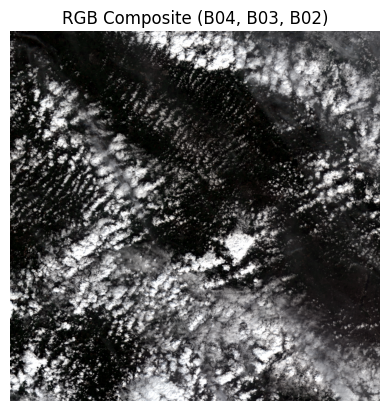

 Saved RGB image to: /content/drive/MyDrive/Sentinel_Images/Outputs/rgb_png/sentinel_rgb.png
 Saved RGB array to: /content/drive/MyDrive/Sentinel_Images/Outputs/rgb_png/sentinel_rgb.npy


In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

# Path to the R10m folder with bands
folder_path = "/content/drive/MyDrive/Sentinel_Images/Outputs/sentinel_extracted/S2B_MSIL2A_20180601T110649_N0500_R137_T30UXC_20230827T052343.SAFE/GRANULE/L2A_T30UXC_A006455_20180601T111624/IMG_DATA/R60m"

# Output directory
output_dir = "/content/drive/MyDrive/Sentinel_Images/Outputs/rgb_png"
os.makedirs(output_dir, exist_ok=True)

# Bands to use (B04 = red, B03 = green, B02 = blue)
band_map = {
    "B04": None,
    "B03": None,
    "B02": None
}

# Find band files in folder
for f in os.listdir(folder_path):
    for band in band_map:
        if band in f and f.endswith(".jp2"):
            band_map[band] = os.path.join(folder_path, f)

# Ensure all bands found
if None in band_map.values():
    print(" Missing one or more RGB bands!")
else:
    # Load and normalize function
    def load_and_normalize(path):
        with rasterio.open(path) as src:
            band = src.read(1).astype(np.float32)
            band = np.clip(band, np.percentile(band, 2), np.percentile(band, 98))
            return ((band - band.min()) / (band.max() - band.min()) * 255).astype(np.uint8)

    # Stack and save RGB
    r = load_and_normalize(band_map["B04"])
    g = load_and_normalize(band_map["B03"])
    b = load_and_normalize(band_map["B02"])
    rgb = np.dstack([r, g, b])

    # Plot for preview
    plt.imshow(rgb)
    plt.title("RGB Composite (B04, B03, B02)")
    plt.axis('off')
    plt.show()

    # Save .png
    png_path = os.path.join(output_dir, "sentinel_rgb.png")
    Image.fromarray(rgb).save(png_path)
    print(f" Saved RGB image to: {png_path}")

    # Save .npy
    npy_path = os.path.join(output_dir, "sentinel_rgb.npy")
    np.save(npy_path, rgb)
    print(f" Saved RGB array to: {npy_path}")

# **Using IRIS for manual classificaiton**


---


After the data has been saved to the drive or moved locally, users are free to take these npy files and use iris or other means to classify them. There are plenty of guides on how to properly install and use IRIS, this notebook will assume that the user is already familiar with the system and has it installed ready to use.

In [ ]:
data_path = "/content/drive/MyDrive/Sentinel_Images/training"

In [ ]:
# loading in image
image = np.load(data_path+ '/sentinel_rgb.npy')

# Extracting the mask_area values from the JSON
x1, y1, x2, y2 = [100, 700, 300, 1000]

# Extracting the region of interest (ROI) from the image
roi = image[y1:y2, x1:x2]

In [ ]:
#check the image shape
image.shape

In [ ]:
#loading mask created using IRIS and converting to binary
mask = cv2.imread("/content/drive/MyDrive/Sentinel_Images/training/mask.png")
binary_mask = np.where(mask[:,:,0] == 0, 1, 0)

# **Creparing for cnn creation by creating test and train regions and trimming image**


To use images in CNN creation, some key preparation needs to be performed. One of the key steps is balancing the classes to avoid skewness of creation, ensuring a higher quality model with better accuracy. The cells also trim the mask to exclude classification on boundaries. This decision means that if the users could not decide if they should classify on the mask boundaries, it would not matter to the model and impact the accuracy.


plotting the mask and sentinel image, and checking the shape of each:  

In [ ]:
# Extract channels 1, 2, and 3
channel_1 = roi[:,:,2]
rgb_image = np.stack([channel_1], axis=-1) # You can add more channels if you want

# Plotting the RGB image and you will see if it corresponds to the mask
plt.imshow(rgb_image)
plt.axis('off')
plt.show()

In [ ]:
# You can also plot the mask
plt.imshow(binary_mask)
plt.axis('off')
plt.show()

In [ ]:
print(binary_mask.shape)
print(roi.shape)

This cell splits the image into patches which the model is then used in creating balanced test and train data later.

In [ ]:
# roi is your data with shape (300, 200, 3)
patches = []

# Iterate over the height and width of the roi, excluding the border pixels
for i in range(1, roi.shape[0] - 1):
    for j in range(1, roi.shape[1] - 1):
        # Extract a (3, 3, 21) patch centered around the pixel (i, j)
        patch = roi[i-1:i+2, j-1:j+2, :]
        patches.append(patch)

# Convert the list of patches to a numpy array
patches_array = np.array(patches)

print(patches_array.shape)

Mask trimming

In [ ]:
# Trim the mask to exclude boundary labels
trimmed_mask = binary_mask[1:-1, 1:-1]

# 1D array of labels
labels = trimmed_mask.flatten()

print(labels.shape)

Balancing the classes:

In [ ]:
#  checking quantity of each class present in the dataset
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))

In [ ]:
# Balancing each class
num_class = 9896 # Adjust it to the amount you get
# Extract indices of both classes
indices_class_0 = np.where(labels == 0)[0]
indices_class_1 = np.where(labels == 1)[0]

# Randomly sample 9396 indices from class 0
sampled_indices_class_0 = np.random.choice(indices_class_0, num_class, replace=False)

# Combine the sampled indices with indices of class 1
combined_indices = np.concatenate([sampled_indices_class_0, indices_class_1])

# Extract the corresponding patches and labels
balanced_patches = patches_array[combined_indices]
balanced_labels = labels[combined_indices]


# Split dataset into training and testing sets with a 1:9 ratio
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    balanced_patches, balanced_labels, test_size=0.1, random_state=42
)

# Check the balance in y_train_balanced
unique, counts = np.unique(y_train_balanced, return_counts=True)
print(dict(zip(unique, counts)))

After running the cell above, training and testing data has been generated by splitting the image into different regions. This data can be saved for reference and then recalled to make sure it has saved properly using the below cells.


In [ ]:
np.save ('/content/drive/MyDrive/Sentinel_Images/train_test/X_train_balanced.npy',X_train_balanced)
np.save ('/content/drive/MyDrive/Sentinel_Images/train_test/X_test_balanced.npy',X_test_balanced)
np.save ('/content/drive/MyDrive/Sentinel_Images/train_test/y_train_balanced.npy',y_train_balanced)
np.save ('/content/drive/MyDrive/Sentinel_Images/train_test/y_test_balanced.npy',y_test_balanced)

X_train = np.load(os.path.join('/content/drive/MyDrive/Sentinel_Images/train_test/X_train_balanced.npy'))
X_test = np.load(os.path.join('/content/drive/MyDrive/Sentinel_Images/train_test/X_test_balanced.npy'))
y_train = np.load(os.path.join('/content/drive/MyDrive/Sentinel_Images/train_test/y_train_balanced.npy'))
y_test = np.load(os.path.join('/content/drive/MyDrive/Sentinel_Images/train_test/y_test_balanced.npy'))

# **Creating the CNN**
These cells are what is used to create the model, using a simple method. While more can be added to increase the complexity of the model, It is not neccisary to create a useable and accurate model in this case

In [ ]:
# Define the model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(3, 3, 3), padding='SAME'))
model.add(layers.MaxPooling2D((2, 2)))
# Add additional convolutional and pooling layers as needed
# ...

# Add dense layers for classification
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))  # 10 is the number of classes

# Compile and train the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10,
        validation_split=0.1)

In [ ]:
#save and load Cnn model
model.save('/content/drive/MyDrive/Sentinel_Images/train_test/modelCNN.h5')
cnn_model = tf.keras.models.load_model('/content/drive/MyDrive/Sentinel_Images/train_test/modelCNN.h5')

# **Model application and isplaying the results**


---


The cell below executes full image roll out complete with percentage of cloud cover in the image, illustrated as a matplot.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# === Load Sentinel-2 image ===
image = np.load('/content/drive/MyDrive/Sentinel_Images/Outputs/rgb_png/sentinel_rgb.npy')
image = image.astype(np.float32)
H, W, C = image.shape

# === Manually extract all 3x3 patches into a batch ===
patches = []
for i in range(1, H - 1):
    for j in range(1, W - 1):
        patch = image[i-1:i+2, j-1:j+2, :]
        patches.append(patch)

patches = np.array(patches)  # shape (N, 3, 3, C)

# === Load model and predict in batches ===
model = load_model('/content/drive/MyDrive/Sentinel_Images/train_test/modelCNN.h5')
y_pred = model.predict(patches, batch_size=512, verbose=1)

# === Convert predictions to class labels ===
if y_pred.shape[-1] == 1:
    pred_classes = (y_pred > 0.5).astype(np.uint8).squeeze()
else:
    pred_classes = np.argmax(y_pred, axis=1)

# === Rebuild full-image mask ===
H_out, W_out = H - 2, W - 2
mask_pred = pred_classes.reshape(H_out, W_out)

# === Visualize ===
plt.figure(figsize=(10, 6))
plt.imshow(mask_pred, cmap='tab10')
plt.title("Fast CNN Full-Image Rollout")
plt.axis("off")
plt.colorbar(label="Class ID")
plt.show()

# === Optional: cloud coverage (class 1 = cloud) ===
cloud_percent = np.sum(mask_pred == 1) / mask_pred.size * 100
print(f"☁️ Cloud coverage: {cloud_percent:.2f}%")

# **Validation tests**
These two cells perform two basic validation tests:




*   Confusion matrix
*   Loss-accuracy plot


These are two common methods to test a model's capabilities and a good indicator if anything has gone wrong in the classification process.
A confusion matrix works by displaying the amount of false positives (bottom left) and false negatives (top right), while a loss accuracy plot simply shows how many errors a model has.




In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)  # Convert probabilities to class labels

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Use the unique class labels from y_test
unique_labels = sorted(set(y_test))

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import matplotlib.pyplot as plt


# Plot the loss and accuracy curves
def plot_training_curves(history):
    # Extract values from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    # Plot model accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

    # Plot model loss
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

# Call the function to plot the curves
plot_training_curves(history)

This bottom section of rollout and validaiton can be used on any sentinel image that the user wishes, allowing a good indicaiton of cloud coverage which would inform the user if the region and time period is a good resoruce to perform furhter remote sensing for other aspects